       product_id  cluster
0           22665      519
1           28640        7
2           13526      842
3           21399       33
4            8504       18
...           ...      ...
32771       12036      258
32772       22709      290
32773       32322      515
32774       19118      539
32775       16083      290

[32776 rows x 2 columns]


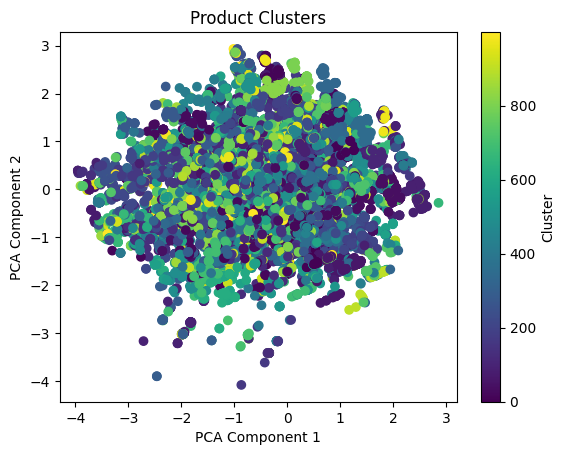

In [1]:
######### LSTM

# Install necessary libraries
!pip install numpy pandas scikit-learn matplotlib tensorflow

# Import libraries
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, InputLayer, Flatten, LayerNormalization
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import EarlyStopping

# Read product catalog data
data = pd.read_csv("product_catalog.csv")

# Handle missing categories by filling with empty list
data['categories'] = data['categories'].fillna('[]')
data['categories'] = data['categories'].apply(literal_eval)  # Convert string to list

# Encode categories
mlb = MultiLabelBinarizer()
categories_encoded = mlb.fit_transform(data['categories'])

# Normalize numerical features
attributes = data[['attribute_1', 'attribute_2', 'attribute_3', 'attribute_4', 'attribute_5']].fillna(0)
scaler = StandardScaler()
attributes_normalized = scaler.fit_transform(attributes)

# Combine features
features = np.hstack([attributes_normalized, categories_encoded])

# Apply clustering
kmeans = KMeans(n_clusters=1000, random_state=42)
data['cluster'] = kmeans.fit_predict(features)

# Print results
print(data[['product_id', 'cluster']])

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=data['cluster'], cmap='viridis')
plt.title('Product Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [2]:

# Read transactions data
transactions = pd.read_csv("transactions.csv")

# Convert 'purchase_date' to datetime object
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])

# Count the number of transactions for each customer
transaction_counts = transactions.groupby('customer_id')['purchase_date'].count().reset_index(name='transaction_count')

# Discretize the transaction counts into categories from 1 to 10
max_transactions = transaction_counts['transaction_count'].max()
bins = np.linspace(0, max_transactions, 11)  # Creates 10 bins
labels = range(1, 11)  # Categories from 1 to 10

# Map each customer to a category based on their transaction count
customer_categories = pd.cut(transaction_counts['transaction_count'], bins=bins, labels=labels, include_lowest=True)

# Add the discretized 'shopping_tendency' category to the transaction data
transaction_counts['shopping_tendency'] = customer_categories

# Merge the transaction count and shopping tendency back into the original 'transactions' DataFrame
transactions = pd.merge(transactions, transaction_counts[['customer_id', 'shopping_tendency']], on='customer_id', how='left')

transactions

,customer_id,product_id,purchase_date,quantity,shopping_tendency
0,38769,3477,2020-06-01,1,3
1,42535,30474,2020-06-01,1,1
2,42535,15833,2020-06-01,1,1
3,42535,20131,2020-06-01,1,1
4,42535,4325,2020-06-01,1,1
...,...,...,...,...,...
1071533,22114,29567,2021-01-31,2,1
1071534,22114,21068,2021-01-31,1,1
1071535,10900,18270,2021-01-31,1,2
1071536,17894,31265,2021-01-31,5,2


In [3]:

# Sort transactions by customer_id, product_id, and purchase_date
transactions = transactions.sort_values(by=['customer_id', 'product_id', 'purchase_date'])

# Calculate the previous purchase date for each customer-product pair
transactions['prev_purchase_date'] = transactions.groupby(['customer_id', 'product_id'])['purchase_date'].shift(1)

# Calculate the number of days since last purchase
transactions['days_since_last_purchase'] = (transactions['purchase_date'] - transactions['prev_purchase_date']).dt.days.fillna(0).astype(int)

# Calculate the last quantity purchased for each customer-product pair
transactions['last_quantity'] = transactions.groupby(['customer_id', 'product_id'])['quantity'].shift(1, fill_value=0).astype(int)

# Calculate product popularity (total number of transactions for each product)
product_popularity = transactions.groupby('product_id')['customer_id'].count().reset_index(name='product_popularity')

# Merge product popularity into the transactions DataFrame
transactions = pd.merge(transactions, product_popularity[['product_id', 'product_popularity']], on='product_id', how='left')

# Calculate days since the first purchase for each customer
first_purchase = transactions.groupby('customer_id')['purchase_date'].min().reset_index()
first_purchase.columns = ['customer_id', 'first_purchase_date']
first_purchase['days_since_first_purchase'] = (pd.to_datetime('today') - first_purchase['first_purchase_date']).dt.days

# Merge this feature back into the transactions DataFrame
transactions = pd.merge(transactions, first_purchase[['customer_id', 'days_since_first_purchase']], on='customer_id', how='left')

transactions

,customer_id,product_id,purchase_date,quantity,shopping_tendency,prev_purchase_date,days_since_last_purchase,last_quantity,product_popularity,days_since_first_purchase
0,0,1505,2020-09-01,1,1,NaT,0,0,71,1675
1,0,6446,2020-12-11,1,1,NaT,0,0,59,1675
2,0,6446,2021-01-15,1,1,2020-12-11,35,1,59,1675
3,0,9325,2020-11-20,1,1,NaT,0,0,210,1675
4,0,12468,2020-08-03,1,1,NaT,0,0,61,1675
...,...,...,...,...,...,...,...,...,...,...
1071533,46137,22403,2021-01-18,1,1,NaT,0,0,74,1611
1071534,46137,22583,2021-01-31,1,1,NaT,0,0,46,1611
1071535,46137,28343,2020-08-08,1,1,NaT,0,0,5,1611
1071536,46137,28900,2020-08-08,2,1,NaT,0,0,448,1611


In [4]:

# Calculate rolling average of quantity for each customer over the past 5 transactions
transactions['rolling_avg_quantity'] = transactions.groupby('customer_id')['quantity'].rolling(5, min_periods=1).mean().reset_index(level=0, drop=True)

# Calculate rolling mean of days between purchases for each customer
transactions['rolling_avg_days_between'] = transactions.groupby('customer_id')['days_since_last_purchase'].rolling(5, min_periods=1).mean().reset_index(level=0, drop=True)

# Calculate additional features like total quantity and average purchase quantity per transaction
total_quantity = transactions.groupby('customer_id')['quantity'].sum().reset_index(name='total_quantity')
average_quantity = transactions.groupby('customer_id')['quantity'].mean().reset_index(name='average_quantity')

# Merge these features into a single DataFrame
customer_features = pd.merge(transaction_counts[['customer_id', 'transaction_count']], total_quantity, on='customer_id')
customer_features = pd.merge(customer_features, average_quantity, on='customer_id')

customer_features

,customer_id,transaction_count,total_quantity,average_quantity
0,0,18,20,1.111111
1,1,15,18,1.200000
2,2,21,25,1.190476
3,3,40,54,1.350000
4,4,23,39,1.695652
...,...,...,...,...
46133,46133,25,27,1.080000
46134,46134,29,35,1.206897
46135,46135,7,13,1.857143
46136,46136,35,69,1.971429


In [5]:

# Apply K-means clustering to the features
scaler = StandardScaler()  # Standardize the features
scaled_features = scaler.fit_transform(customer_features[['transaction_count', 'total_quantity', 'average_quantity']])

# Fit the K-means model
kmeans = KMeans(n_clusters=1000, random_state=42)
customer_features['cluster_customer'] = kmeans.fit_predict(scaled_features)

# Merge the cluster labels back into the original 'transactions' DataFrame
transactions = pd.merge(transactions, customer_features[['customer_id', 'cluster_customer']], on='customer_id', how='left')

# Merge transaction data with product catalog to add cluster information
merged_df = pd.merge(
    transactions,
    data[['product_id', 'cluster']],  # Select columns for merging
    on='product_id',
    how='left'
)

# Sort by customer_id, cluster, and purchase_date
merged_df = merged_df.sort_values(by=['customer_id', 'cluster', 'purchase_date'])

# Calculate cumulative sum of quantities for each customer-cluster
merged_df['cumulative_quantity'] = merged_df.groupby(['customer_id', 'cluster'])['quantity'].cumsum()

# Calculate last cumulative quantity
merged_df['last_cumulative_quantity'] = merged_df.groupby(['customer_id', 'cluster'])['cumulative_quantity'].shift(1, fill_value=0).astype(int)

merged_df

,customer_id,product_id,purchase_date,quantity,shopping_tendency,prev_purchase_date,days_since_last_purchase,last_quantity,product_popularity,days_since_first_purchase,rolling_avg_quantity,rolling_avg_days_between,cluster_customer,cluster,cumulative_quantity,last_cumulative_quantity
16,0,31683,2020-12-04,1,1,NaT,0,0,1515,1675,1.2,13.2,361,34,1,0
12,0,28231,2020-11-20,1,1,NaT,0,0,41,1675,1.0,37.8,361,41,1,0
13,0,28231,2020-12-11,1,1,2020-11-20,21,1,41,1675,1.0,42.0,361,41,2,1
14,0,28231,2021-01-25,2,1,2020-12-11,45,1,41,1675,1.2,25.8,361,41,4,2
11,0,26387,2020-10-09,1,1,NaT,0,0,453,1675,1.0,37.8,361,71,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071533,46137,22403,2021-01-18,1,1,NaT,0,0,74,1611,1.0,0.0,5,322,1,0
1071532,46137,20209,2020-08-08,1,1,NaT,0,0,1101,1611,1.0,0.0,5,356,1,0
1071528,46137,2550,2021-01-18,1,1,NaT,0,0,269,1611,1.0,0.0,5,450,1,0
1071530,46137,11338,2021-01-31,1,1,NaT,0,0,95,1611,1.0,0.0,5,491,1,0


In [6]:

# Select columns for training
train_df = merged_df[['customer_id', 'product_id', 'cluster', 'last_quantity',
                      'days_since_last_purchase', 'purchase_date', 'quantity', 'cumulative_quantity',
                      'last_cumulative_quantity', 'shopping_tendency', 'cluster_customer', 'product_popularity',
                      'days_since_first_purchase', 'rolling_avg_quantity', 'rolling_avg_days_between']]

# Sort train_df by purchase_date in descending order for prediction
train_df['purchase_date'] = pd.to_datetime(train_df['purchase_date'])
train_df = train_df.sort_values(by='purchase_date', ascending=False)

# Create a new DataFrame containing only the last purchase for each customer-product pair
train_df_last = train_df.groupby(['customer_id', 'product_id']).first().reset_index()


<ipython-input-6-4de74c47517c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['purchase_date'] = pd.to_datetime(train_df['purchase_date'])


In [7]:

# Prepare data for LSTM model
def prepare_data(df, time_steps):
    data = []
    for i in range(len(df) - time_steps):
        data.append(df.iloc[i:(i + time_steps)].values)
    return np.array(data)

time_steps = 10  # Define the number of time steps for LSTM input

# Prepare features and target
features = train_df[['cluster', 'last_quantity', 'last_cumulative_quantity', 'shopping_tendency', 'cluster_customer',
                     'product_popularity', 'days_since_first_purchase', 'rolling_avg_quantity', 'rolling_avg_days_between']].values
target = train_df['days_since_last_purchase'].values

# Reshape features for LSTM
features_lstm = prepare_data(pd.DataFrame(features), time_steps)
target_lstm = target[time_steps:]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features_lstm, target_lstm, test_size=0.2, random_state=42)


In [8]:

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, features.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train LSTM model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

print("features_lstm shape:", features_lstm.shape)
print("target_lstm shape:", target_lstm.shape)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
13395/13395 ━━━━━━━━━━━━━━━━━━━━ 52s 4ms/step - loss: 1945.6018 - val_loss: 1092.8190
Epoch 2/10
13395/13395 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - loss: 1078.1995 - val_loss: 1069.1602
Epoch 3/10
13395/13395 ━━━━━━━━━━━━━━━━━━━━ 52s 4ms/step - loss: 1075.8918 - val_loss: 1077.6960
Epoch 4/10
13395/13395 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - loss: 1069.1763 - val_loss: 1067.7896
Epoch 5/10
13395/13395 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 1072.0074 - val_loss: 1066.3544
Epoch 6/10
13395/13395 ━━━━━━━━━━━━━━━━━━━━ 86s 4ms/step - loss: 1074.0532 - val_loss: 1066.3700
Epoch 7/10
13395/13395 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - loss: 1068.3180 - val_loss: 1067.6492
Epoch 8/10
13395/13395 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - loss: 1071.6503 - val_loss: 1062.6351
Epoch 9/10
13395/13395 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - loss: 1058.7546 - val_loss: 1067.2782
Epoch 10/10
13395/13395 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - loss: 1069.4177 - val_loss: 1061.4454
features_lstm shape: (1071528

In [9]:

# Read test csv
test = pd.read_csv("test.csv")

# Merge cluster and quantity information into the test DataFrame
test = pd.merge(test, train_df_last[['customer_id', 'product_id', 'cluster', 'quantity',
                                     'cumulative_quantity', 'shopping_tendency', 'cluster_customer',
                                     'product_popularity', 'days_since_first_purchase', 'rolling_avg_quantity',
                                     'rolling_avg_days_between']],
                on=['customer_id', 'product_id'], how='left')

# Rename the 'quantity' column to 'last_quantity'
test = test.rename(columns={'quantity': 'last_quantity', 'cumulative_quantity': 'last_cumulative_quantity'})


X_test = test[['cluster', 'last_quantity', 'last_cumulative_quantity', 'shopping_tendency',
               'cluster_customer', 'product_popularity', 'days_since_first_purchase', 'rolling_avg_quantity',
               'rolling_avg_days_between']].values

# Create sequences for LSTM
X_test_lstm = []
for i in range(len(X_test) - time_steps + 1):
    X_test_lstm.append(X_test[i:(i + time_steps)])
X_test_lstm = np.array(X_test_lstm)

# Predict the number of days since the last purchase using the LSTM model
predictions = model.predict(X_test_lstm).flatten()

# Since we might have fewer predictions than test samples due to sequence length,
# we need to handle this by aligning the predictions properly
predictions = np.concatenate([predictions, np.zeros(len(test) - len(predictions))])

# Ensure the predicted days are integers
test['prediction'] = predictions.clip(min=0).astype(int)

# Merge the test data with the last purchase data to add the purchase date
test_df_merged = test.merge(train_df_last[['customer_id', 'product_id', 'purchase_date']],
                            on=['customer_id', 'product_id'], how='left')


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [10]:

# If the predicted date is before February 1, 2021, keep adding the prediction days
# to simulate consistent purchases until the date is on or after February 1.
def adjust_date(row):
    if row['prediction'] != 0:
        while row['predicted_purchase_date'] < pd.to_datetime('2021-02-01'):
            row['predicted_purchase_date'] += pd.to_timedelta(row['prediction'], unit='D')
    return row['predicted_purchase_date']

# Calculate the initial predicted_purchase_date
test_df_merged['predicted_purchase_date'] = test_df_merged['purchase_date'] + pd.to_timedelta(test_df_merged['prediction'], unit='D')

# Apply the adjustment function to each row
test_df_merged['predicted_purchase_date'] = test_df_merged.apply(adjust_date, axis=1)

# Calculate the number of days between the predicted purchase date and February 1st, 2021
feb_1st_2021 = pd.to_datetime('2021-02-01')
test_df_merged['days_from_feb_1st'] = (test_df_merged['predicted_purchase_date'] - feb_1st_2021).dt.days

# Map day values to target values (weeks)
def map_weeks_to_feb(days):
    if days > 29:
        return 0
    elif 0 <= days <= 8:
        return 1
    elif 8 < days <= 15:
        return 2
    elif 15 < days <= 22:
        return 3
    elif 22 < days <= 29:
        return 4
    else:
        return 0

# Apply the mapping function
test_df_merged['prediction'] = test_df_merged['days_from_feb_1st'].apply(map_weeks_to_feb).astype(int)

# Select relevant columns and save the result to a CSV file
df_selected = test_df_merged[['id', 'customer_id', 'product_id', 'prediction']]
df_selected.to_csv('submission.csv', index=False)
print(df_selected['prediction'].value_counts())


prediction
1    3283
3    2823
2    2729
4    1094
0      71
Name: count, dtype: int64
